# env 및 langsmith 

In [20]:
from dotenv import load_dotenv
from langsmith import Client

load_dotenv()
client = Client()

# 그래프 상태 정의

In [21]:
from typing import TypedDict
class RealEstateState(TypedDict): # 그래프의 상태를 정의하는 클래스
    real_estate_type: str  # 부동산 유형 (예: 아파트, 상가)
    keywordlist: list[str] # 키워드 리스트
    questions: list[str]        # 유저 질문
    query: str             # 생성된 SQL 쿼리
    results: list[dict]          # 쿼리 결과

# 필터, 재질문 노드 생성 및 조건부 엣지

In [22]:
from langgraph.graph import StateGraph, START, END
from langchain.prompts import PromptTemplate
from langchain_openai.chat_models.base import ChatOpenAI
# Step 1: LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.8)
# Step 2: StateGraph 정의
graph = StateGraph(RealEstateState)
# Step 3: 노드 정의
## 필터링 노드
def filter_node(state: RealEstateState) -> RealEstateState :
    filter_prompt = PromptTemplate(
        input_variables=["questions"],
        template=""" '{questions}'이 부동산과 관련된 질문인지를 파악하고 다음과 같은 규칙을 지켜라
        1. 부동산 관련 질문이 아니면 'None'을 반환해라
        2. 부동산 관련 질문 중 에서 매매면 '매매'를 반환해라
        3. 전세 그리고 월세랑 관련된 질문이면 '전월세'를 반환해라.
        """)
    prompt=filter_prompt.format(questions=state["questions"])
    response = llm(messages=[{"role": "system", "content": prompt}])
    real_estate_type = response.content
    return RealEstateState(real_estate_type=real_estate_type)

def re_questions(state: RealEstateState) -> RealEstateState:
    print("=================================")
    print("[re_questions] 질문이 부동산 관련이 아니거나 제대로 인식되지 않았습니다.")
    new_question = input("새로운 부동산 질문을 입력해주세요: ")
    print("=================================")
    # 수정된 질문을 state에 업데이트
    return RealEstateState(questions=new_question)

def fiter_router(state: RealEstateState):
    # This is the router
    real_estate_type = state["real_estate_type"]
    if real_estate_type == "매매":
        return "매매"
    elif real_estate_type == "전월세":
        return "전월세"
    else:
        return 'None'

# DB 생성

In [23]:
import sqlite3
from langchain_community.utilities.sql_database import SQLDatabase
from sqlalchemy import create_engine
from sqlalchemy.pool import StaticPool

def get_db_engine(db_path):
    """로컬 SQLite DB 파일과 연결된 엔진을 생성합니다."""
    try:
        # SQLite DB 파일과 연결
        connection = sqlite3.connect(db_path, check_same_thread=False)
        # SQLAlchemy 엔진 생성
        engine = create_engine(
            f"sqlite:///{db_path}",
            poolclass=StaticPool,
            connect_args={"check_same_thread": False}
        )
        return engine
    except Exception as e:
        print(f"데이터베이스 연결 중 오류 발생: {str(e)}")
        return None
    
    
# DB 파일 경로 지정
db_path = './data/real_estate.db'
engine = get_db_engine(db_path)
db = SQLDatabase(
    engine,
    sample_rows_in_table_info=False  # 샘플 행 조회 비활성화
)


# KeyWord 추출

In [24]:
def keyword_filter(state: RealEstateState) -> RealEstateState:
    keyword_filter_prompt = PromptTemplate(
        input_variables=["questions"],
        template=""" '{questions}'을 보고 문장에 핵심 키워드들을 추출하고 다음과 같은 규칙을 지켜라
        1. 반환형식은 집합(set)으로 반환해라
        """)
    prompt=keyword_filter_prompt.format(questions=state["questions"])
    response = llm(messages=[{"role": "system", "content": prompt}])
    keyword_filter = response.content
    return RealEstateState(keywordlist=keyword_filter)

In [25]:
def missing_keyword(state: RealEstateState) -> RealEstateState:
    print("=================================")
    print("[missing_keyword] 키워드가 부족합니다. 좀 더 자세하게 적어주세요!!!")
    new_keyword = input("키워드를 입력해주세요: ")
    print("=================================")
    # 수정된 질문을 state에 업데이트
    return RealEstateState(questions=new_keyword)

In [26]:
def keyword_router(state: RealEstateState):
    # This is the router
    keyword_list = state["keywordlist"]
    if len(keyword_list) == 0:
        return "missing_keyword"
    elif ('매매', '월세', '전세', '지역', '액수', '가격') not in keyword_list:
        return "missing_keyword"
    else:
        return "None"

# 전월세 테이블 노드 생성

In [27]:
def property_rental(state: RealEstateState) -> RealEstateState:
    property_rental = db.get_table_info(table_names=["property_rentals", "property_info", "property_locations"])

    rental_prompt = """
    질문:
    {questions}

    사용 가능한 테이블 스키마:
    {property_rental}

    당신은 SQL 전문가입니다. 
    데이터베이스는 {dialect} 방언을 사용합니다.

    다음 규칙을 따라주세요:
    1. 한국어로 응답해주세요.
    2. SQL 쿼리를 작성할 때는 명확하고 효율적이어야 합니다.
    3. 결과는 최대 {top_k}개까지만 보여주세요.
    4. 금액에 관련된 쿼리를 작성할 때는 쉼표(,)를 제거하고 숫자로 변환해야 합니다.
    5. 에러가 발생하면 원인을 설명하고 수정된 쿼리를 제시해주세요.
    6. rental_type이 30051B1는 전세입니다.
    7. rental_type이 30051B2는 월세입니다.
    8. 별도의 멘트 없이 오직 쿼리만 작성해 주세요.
    9. `CAST(... AS DECIMAL)` 대신 `CAST(... AS INTEGER)`를 사용하세요.
    10. 무조건 나와야 하는 값은 다음과 같습니다:
        - pl.sigungu
        - pi.description
        - pr.deposit
        - pl.latitude
        - pl.longitude

    예시:

    - 질문: "서울시 강남구 10억 이하 전세를 추천해줘"
    
    SELECT 
        pl.sigungu,
        pi.description,
        pr.deposit AS "보증금(만원)",
        pl.latitude,
        pl.longitude
    FROM property_rentals pr
    JOIN property_info pi ON pr.property_id = pi.property_id
    JOIN property_locations pl ON pi.location_id = pl.location_id
    WHERE pl.sigungu LIKE '%강남구%'
    AND pr.rental_type = '30051B1'
    AND CAST(REPLACE(pr.deposit, ',', '') AS INTEGER) <= 10000;

    이런 식으로 쿼리를 짜주세요.
    """

    prompt = rental_prompt.format(
        dialect="SQLite",
        top_k=5,
        property_rental=property_rental,
        questions=state["questions"]
    )

    response = llm(messages=[{"role": "system", "content": prompt}])

    llm_query = response.content

    return RealEstateState(query=llm_query)

# 매매 테이블 노드 생성

In [28]:
def property_sales(state: RealEstateState) -> RealEstateState:
    property_sales = db.get_table_info(table_names=["property_sales", "property_info", "property_locations"])
    sales_prompt = """
    질문을 기반으로 SQL 쿼리를 작성하세요.

가능한 테이블 스키마와 데이터베이스 방언을 고려하되, 아래의 규칙을 반드시 준수하십시오:

- 한국어로 응답하세요.
- 작성한 쿼리는 명확하며 효율적이어야 합니다.
- 결과는 최대 {top_k}개로 제한합니다.
- 금액 관련 숫자는 쉼표(,)를 제거하고 숫자로 변환합니다.
- 쿼리 오류 시 원인을 설명하고 수정된 쿼리를 제시합니다.
- 쿼리만 작성하며, 추가적인 설명 없이 결과를 제공합니다.
- 금액 변환 시 `CAST(... AS INTEGER)`를 사용합니다.
- 쿼리에 꼭 포함해야 할 값: 
  - pl.sigungu
  - pi.description
  - ps.price
  - pl.latitude
  - pl.longitude

# Steps

1. 주어진 질문을 파악하고 요구사항을 SQL 쿼리로 변환합니다.
2. 필요한 테이블과 그 관계를 파악하여 JOIN 구문을 사용합니다.
3. WHERE 절을 통해 필요한 조건을 부여합니다.
4. SELECT 문의 결과는 설명된 필요한 필드만 포함하도록 합니다.
5. 결과가 {top_k}개 이하인지 확인합니다.
6. 쿼리에 에러가 있을 경우 원인을 찾아 수정합니다.
7. price는 쉼표를 제거하고 숫자로 변환시 단위가 만원임을 유의합니다.

# Output Format

- 오직 SQL 쿼리만 작성하세요. 
- 쿼리는 간단명료하고 조건에 맞춰 설계해야 합니다.

# Examples

- 질문: "서울시 강남구 10억 이하 매물을 추천해줘"

```sql
SELECT 
  pl.sigungu,
  pi.description,
  ps.price AS "금액(만원)",
  pl.latitude,
  pl.longitude
FROM property_sales ps
JOIN property_info pi ON ps.property_id = pi.property_id
JOIN property_locations pl ON pi.location_id = pl.location_id
WHERE pl.sigungu LIKE '%강남구%'
AND CAST(REPLACE(ps.price, ',', '') AS INTEGER) <= 100000
LIMIT {top_k};
```

# Notes

- 에러가 발생 시 문제의 원인을 파악하고, 적절히 수정한 쿼리를 제공해야 합니다.
- 쿼리는 주어진 데이터베이스 방언 {dialect}에 맞게 작성되어야 합니다.
- 금액은 반드시 쉼표를 제거한 정수형으로 변환해야 합니다.
"""

    prompt=sales_prompt.format(
        dialect="SQLite",
        top_k=5, 
        property_sales=property_sales,
        questions=state["questions"]
    )
    
    response = llm(messages=[{"role": "system", "content": prompt}])
    llm_query = response.content
    return RealEstateState(query=llm_query)

# SQL Query 다듬는 노드

In [29]:
def clean_sql_response(state: RealEstateState) -> RealEstateState:
    # 'query' 키는 항상 존재한다고 가정
    query = state['query']

    # 코드 블록(````sql ... `````) 제거
    if query.startswith("```sql") and query.endswith("```"):
        query = query[6:-3].strip()  # "```sql" 제거 후 앞뒤 공백 제거

    # SQL 문 끝에 세미콜론 추가 (필요시)
    if not query.strip().endswith(";"):
        query = query.strip() + ";"
        

    # 상태 업데이트
    return RealEstateState(query=query)

# Query 결과 노드

In [30]:
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool

def run_query(state: RealEstateState) -> RealEstateState:
    tool = QuerySQLDataBaseTool(db=db)
    results = tool._run(state["query"])

    return RealEstateState(results=results)

# Answer 노드

In [31]:
def answer(state: RealEstateState) -> RealEstateState:
    results = state["results"]

    if len(results) == 0:
        return RealEstateState(answer="검색 결과가 없습니다.")

    answer_prompt = """
    너는 글쓰는 사람이야
    주어진 데이터를 참고해서 유저한테 보여줄 글을 이쁘게 써줘
    형식은 Json이야
    
    주어진 데이터:
    {results}
    """
    prompt = answer_prompt.format(results=state["results"])

    response = llm(messages=[{"role": "system", "content": prompt}])

    print(response.content)

    return RealEstateState(answer=response.content)

# add_node()

In [32]:
graph.add_node("Filter Question", filter_node)
graph.add_node('Re_Questions', re_questions)
graph.add_node("Property Rentals", property_rental)
graph.add_node('Property Sales', property_sales)
graph.add_node('Clean Sql Response', clean_sql_response)
graph.add_node("Run Query", run_query)
graph.add_node("Answer", answer)

# 그래프 실행

```json
{
  "properties": [
    {
      "location": "강남구",
      "description": null,
      "price": 360000,
      "latitude": 37.4931444,
      "longitude": 127.0590787
    },
    {
      "location": "강남구",
      "description": "♡ since 2003년 미 노출중인 A급 매물 다수 보유 중\n♣ 같은자리 20년이상 경력과 신뢰를 바탕으로 고객님 니즈에 맞춰서 최적의 컨설팅을 해드립니다.\n\n☎  02  576  7489     010  5162  7489  새롬 공인중개사사무소 (포이초등학교앞)\n\n-------------\n\n[매물정보] ---- 다양한 조건에 맞춰서 최대한 협의 가능합니다.!!!\n\n▶ 지하1층~지상4층 현재 집회및 문화시설로 되어있지만 올근생으로 변경가능\n★ 국악고 및 양재ic인근 외부 진출입 편리한 위치\n★ 개발...",
      "price": 780000,
      "latitude": 37.4751819,
      "longitude": 127.0529911
    },
    {
      "location": "강남구",
      "description": "♥ 같은자리 20년 경력만큼 미 노출중인 물건 다수 보유중이니 문의주시면 마음에 꼭 드시는 물건으로 보답하겠습니다 ♥\n♧새롬공인중개사사무소(포이초등학교앞))/ {매수,매도,갭투자 문의환영}\n\n☎ 02 576 7489     010 5162 7489 [편리한 문자 문의 가능]\n=================\n\n[매물특징]\n\n★ 강남 입성의 마지막 기회 개포동 4동 재개발!!!\n+개포동의 입지 가치와 그동안 개발을 막아왔던 각종 규제가 해제되면서 구룡마을 등을 포함한\n  개포동은 대규모 개발이 가능한 강남구...",
      "price": 330000,
   

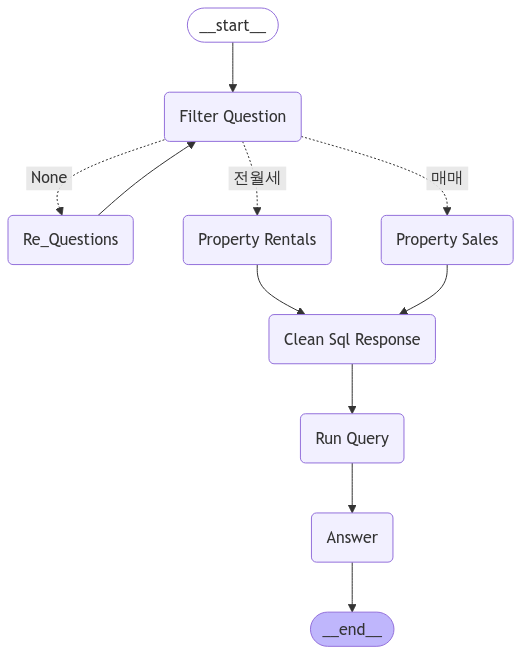

In [33]:
from IPython.display import Image, display

# 조건부 엣지 추가
graph.add_conditional_edges(
    "Filter Question",
    fiter_router,
    { 'None': "Re_Questions", '매매': "Property Sales", '전월세': 'Property Rentals'}
)


# START에서 'Filter Question' 노드로 엣지 추가
graph.add_edge(START, "Filter Question")
graph.add_edge("Re_Questions", "Filter Question")
graph.add_edge("Property Rentals", 'Clean Sql Response')
graph.add_edge("Property Sales", 'Clean Sql Response')
graph.add_edge('Clean Sql Response', 'Run Query')
graph.add_edge('Run Query', "Answer")
graph.add_edge("Answer", END)


# 그래프 컴파일
app = graph.compile()

# 그래프 실행
result = app.invoke({'questions':input("안녕하세요!!! 부동산 챗봇입니다!!! 부동산에 대한 질문을 입력해주세요: ")})
print(result) 


graph_image = app.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [34]:
print(result['query'])

SELECT 
  pl.sigungu,
  pi.description,
  CAST(REPLACE(ps.price, ',', '') AS INTEGER) AS "금액(만원)",
  pl.latitude,
  pl.longitude
FROM property_sales ps
JOIN property_info pi ON ps.property_id = pi.property_id
JOIN property_locations pl ON pi.location_id = pl.location_id
WHERE pl.sigungu LIKE '%강남구%'
AND CAST(REPLACE(ps.price, ',', '') AS INTEGER) <= 1000000
LIMIT 5;


In [58]:
import json
import re

# 사용자 입력 받기
questions = input("질문을 입력해주세요: ")

# 한글 숫자 표현 변환 함수
def convert_price_korean_to_numeric(price_str):
    """Convert Korean price format (e.g., '3억') to numeric format (e.g., 30000)."""
    match = re.match(r"(\d+)(억)?(\d+)?(천)?", price_str)
    if not match:
        return None  # 변환 실패 시 None 반환
    
    billion = int(match.group(1)) if match.group(1) else 0
    million = int(match.group(3)) if match.group(3) else 0

    # '억'이 있으면 천 단위로 계산
    total = billion * 10000 + million
    return total

# 프롬프트 정의
filter_prompt = PromptTemplate(
    input_variables=["questions"],
    template="""
    {questions}에 대한 정보를 추출하고 다음과 같은 규칙을 따르세요:

    Extract keywords from the input text and structure them according to the specified rules.

    Ensure the output meets the following criteria:
    - The output must be in JSON format with specific keys: "지역" (region), "가격" (price), and "거래유형" (transaction type - 매매, 전세, 월세).
    - Convert the price to a numerical value (e.g., from "10억" to 100000).
    - If a keyword is missing in the question, fill the JSON field with '없음'.

    Output Format:
    Produce a JSON object containing the extracted and formatted data. Keep fields as '없음' if not identified.
    """
)

# 템플릿을 기반으로 프롬프트 생성
prompt = filter_prompt.format(questions=questions)

# LLM 호출
response = llm(messages=[{"role": "system", "content": prompt}])

# 응답 처리
try:
    # JSON 부분 추출
    json_match = re.search(r"\{.*\}", response.content, re.DOTALL)
    if json_match:
        json_data = json_match.group(0)  # JSON 문자열 추출
        extracted_data = json.loads(json_data)  # JSON 파싱

        # 가격 변환 적용
        if "가격" in extracted_data and isinstance(extracted_data["가격"], int):
            price_str = f"{extracted_data['가격'] // 100000000}억"
            extracted_data["가격"] = convert_price_korean_to_numeric(price_str)

        print("추출된 데이터:", extracted_data)
    else:
        print("JSON 형식을 찾을 수 없습니다. 응답 내용:", response.content)
except json.JSONDecodeError:
    print("JSON 변환에 실패했습니다. 응답 내용:")
    print(response.content)


추출된 데이터: {'지역': '강남', '가격': '없음', '거래유형': '없음'}
